## Introduction
####  Data analysis & visualiztion on the skills of data scientists from the job description of 2 hiring websites

In [149]:
from __future__ import print_function
import pandas as pd
import numpy as np

# Text preprocessing
import os,re

# Disable warning of 3 types
import warnings

#Plotting
import matplotlib.pyplot as plt
import matplotlib.cm as cm
import altair as alt
import pyLDAvis
import pyLDAvis.sklearn
pyLDAvis.enable_notebook()


# Other utils
from tqdm import tqdm  # Progress bar

#EDA tools.
import dtale

# nlp text cleaning
import nltk
import re
import string
from nltk.tokenize import word_tokenize, sent_tokenize
from nltk.corpus import stopwords
from nltk.stem import PorterStemmer # or LancasterStemmer, RegexpStemmer, SnowballStemmer

# Transformers
from transformers import pipeline
import ipywidgets as widgets
from transformers import pipeline
from sentence_transformers import SentenceTransformer

# Clustering algorithms
from sklearn.decomposition import PCA
from sklearn.cluster import KMeans, MiniBatchKMeans
from sklearn.decomposition import LatentDirichletAllocation
from scipy.cluster.hierarchy import ward, dendrogram
from sklearn.metrics.pairwise import cosine_similarity

from sklearn.feature_extraction.text import CountVectorizer, TfidfVectorizer, ENGLISH_STOP_WORDS
from nltk.stem.snowball import SnowballStemmer

In [ ]:
# load main table only including the jobs of data scientists
ds_file= './01_data/output/datascientists.csv'
df_main=pd.read_csv(ds_file)

In [ ]:
# Drop the duplicated job postings 
df_main.drop_duplicates(subset=['employer','description','title','location'],inplace=True)

In [ ]:
# load skills produced by azure
az_skills= './01_data/output/az_skills.csv'
df_skills=pd.read_csv(az_skills)

In [ ]:
df_skills=df_skills[df_skills['category'].isin(['Skill','Product','Person'])]

In [ ]:
len(df_skills)

In [ ]:
# Drop the duplicated skills in the same job description
df_skills.drop_duplicates(subset=['id','skill'],inplace=True)

In [ ]:
len(df_skills)

In [ ]:
df_id_cnt=df_skills.groupby(['id']).count()['skill']
df_id_cnt=df_id_cnt.reset_index()

In [ ]:
df_id_cnt.describe()

In [ ]:
df_skills_cnt=df_skills.groupby(['skill']).count()['id']
df_skills_cnt=df_skills_cnt.reset_index()

In [ ]:
df_skills_cnt.sort_values('id',ascending=False)

In [ ]:
# Perform EDA to check main table
d0 = dtale.show(df_main)
d0.open_browser()

## Embedding-based clustering analysis

In [ ]:
onlinemodel='bert-large-nli-mean-tokens'
embedder = SentenceTransformer(onlinemodel)

In [ ]:
#queries = list(jobs['job_desc'][0:30])
queries = list(df_skills['skill'].unique())
query_embeddings = embedder.encode(queries)

In [ ]:

# Elbow criterion - Determine optimal numbers of clusters by elbow rule.
def elbow_plot(data, maxK=15, seed_centroids=None):
    """
        parameters:
        - data: pandas DataFrame (data to be fitted)
        - maxK (default = 10): integer (maximum number of clusters with which to run k-means)
        - seed_centroids (default = None ): float (initial value of centroids for k-means)
    """
    sse = []
    K= range(1, maxK)
    for k in K:
        if seed_centroids is not None:
            seeds = seed_centroids.head(k)
            kmeans = KMeans(n_clusters=k, max_iter=500, n_init=100, random_state=0, init=np.reshape(seeds, (k,1))).fit(data)
            #data["clusters"] = kmeans.labels_
        else:
            kmeans = KMeans(n_clusters=k, max_iter=300, n_init=100, random_state=0).fit(data)
            #data["clusters"] = kmeans.labels_
        print("k: ", k,"sse: ",kmeans.inertia_)
        # Inertia: Sum of distances of samples to their closest cluster center
        sse.append(kmeans.inertia_)
    plt.figure()
    plt.plot(K,sse,'bx-')
    plt.xlabel('k')
    plt.ylabel('Sum_of_squared_distances')
    plt.title('Elbow Method For Optimal k')
    plt.show()
    return kmeans.labels_

# Run Elbow
elbow_plot(query_embeddings)

In [ ]:
# As clustering algorithm KMeams is a perfect fit.
num_clusters = 3
clf = KMeans(n_clusters=num_clusters, 
            max_iter=100, 
            init='k-means++', 
            n_init=1)
clf.fit_predict(query_embeddings)
cluster_assignment = clf.labels_

cdf=pd.DataFrame(columns=["cluster_id","sentence_id","sentence"])

for i in range(len(cluster_assignment)):
    new_row=pd.Series(data={"cluster_id":cluster_assignment[i],
                                "sentence_id":i,
                                "sentence":queries[i]
                           }
                            )
    cdf=cdf.append(new_row,ignore_index=True)

cdf.head()

In [ ]:
# Perform EDA to check clustering result
d1 = dtale.show(cdf)
d1.open_browser()

In [ ]:
# Using PCA to reduce the dimension to project the result to 2-d scatter plot

pca = PCA(n_components=2)
principalComponents = pca.fit_transform(query_embeddings)

df_pca = pd.DataFrame(data = principalComponents
             , columns = ['principal component 1', 'principal component 2'])

df_pca['skills']=queries

In [ ]:
# Perform EDA to check clustering result
d2 = dtale.show(df_pca)
d2.open_browser()
# Using PCA, it could not clearly identify different group

In [ ]:
# Combine PCA results with K-means results to see clustering
df_k=df_pca.merge(cdf,right_on=['sentence'],left_on=['skills'])

In [ ]:
# Perform EDA to check clustering result
d3 = dtale.show(df_k)
d3.open_browser()

In [64]:
tf_vectorizer = CountVectorizer(strip_accents = 'unicode',
                                stop_words = 'english',
                                lowercase = True,
                                token_pattern = r'\b[a-zA-Z]{3,}\b',
                                max_df = 0.5, 
                                min_df = 10)
dtm_tf = tf_vectorizer.fit_transform(df_main['description_cln'])
tfidf_vectorizer = TfidfVectorizer(**tf_vectorizer.get_params())
dtm_tfidf = tfidf_vectorizer.fit_transform(df_main['description_cln'])

In [71]:
# Using LDA to cluster skills
lda_tf = LatentDirichletAllocation(n_components=3, random_state=0)
lda_tf.fit(dtm_tf)
# for TFIDF DTM
lda_tfidf = LatentDirichletAllocation(n_components=3, random_state=0)
lda_tfidf.fit(dtm_tfidf)

LatentDirichletAllocation(n_components=3, random_state=0)

In [72]:
pyLDAvis.sklearn.prepare(lda_tf, dtm_tf, tf_vectorizer)

PreparedData(topic_coordinates=              x         y  topics  cluster       Freq
topic                                                
1     -0.002891 -0.066478       1        1  59.770204
2     -0.115299  0.034474       2        1  24.163535
0      0.118190  0.032004       3        1  16.066261, topic_info=             Term         Freq        Total Category  logprob  loglift
1182       strong  1197.000000  1197.000000  Default  30.0000  30.0000
363           div   308.000000   308.000000  Default  29.0000  29.0000
55      analytics   595.000000   595.000000  Default  28.0000  28.0000
1166  statistical   445.000000   445.000000  Default  27.0000  27.0000
1246        tools   457.000000   457.000000  Default  26.0000  26.0000
...           ...          ...          ...      ...      ...      ...
50       analysis    62.654878   555.294019   Topic3  -5.2024  -0.3534
1167   statistics    60.107050   462.608496   Topic3  -5.2440  -0.2123
237      computer    56.538127   457.928709   Topic3  -5.3052  -0.2633
337       develop    53.292630   349.839751   Topic3  -5.3643  -0.0532
1214         team    54.061092   628.593392   Topic3  -5.3500  -0.6249

[265 rows x 6 columns], token_table=      Topic      Freq     Term
term                          
1         1  0.606587  ability
1         2  0.109678  ability
1         3  0.284268  ability
2         1  0.552737     able
2         2  0.126669     able
...     ...       ...      ...
1333      2  0.530848    world
1333      3  0.174422    world
1341      1  0.804632    years
1341      2  0.132104    years
1341      3  0.064050    years

[440 rows x 3 columns], R=30, lambda_step=0.01, plot_opts={'xlab': 'PC1', 'ylab': 'PC2'}, topic_order=[2, 3, 1])

In [ ]:
# The above result present topic modelling may not suggest meaningful clustering.
# However, it may suggest I can combine all skills into sentence, then using topic modelling to analysis.

In [74]:
df_k

principal component 1  principal component 2  \
0                  2.494478              -0.593761   
1                  5.630182               0.382206   
2                  8.098710              -1.243574   
3                  1.400165              -1.301121   
4                  5.515015              -2.715451   
...                     ...                    ...   
4681              -4.127596               7.157611   
4682               4.274004              -0.779428   
4683              -3.224554              -2.086409   
4684              -5.527805               2.553873   
4685               3.450155               1.400502   

                             skills cluster_id sentence_id  \
0                technologie-themen          1           0   
1           artificial intelligence          1           1   
2                  machine learning          1           2   
3                          datasets          1           3   
4                     cybersecurity          1           4   
...                             ...        ...         ...   
4681                             ee          2        4681   
4682  distributed computing systems          1        4682   
4683            technique selection          0        4683   
4684                         agiler          2        4684   
4685                    algorithmes          1        4685   

                           sentence  
0                technologie-themen  
1           artificial intelligence  
2                  machine learning  
3                          datasets  
4                     cybersecurity  
...                             ...  
4681                             ee  
4682  distributed computing systems  
4683            technique selection  
4684                         agiler  
4685                    algorithmes  

[4686 rows x 6 columns]

In [78]:
    height=600
    width=800
    # Create scatter plot to display death and confirmed cases by countries
    scat=alt.Chart(df_k).mark_circle(size=100).encode(
        y=alt.Y("principal component 1", axis=alt.Axis(format='f', title='PC 1')),
        x=alt.X("principal component 2",axis=alt.Axis(format='f', title='PC 2')),
        #color=alt.condition(select_country,alt.value("red"),alt.value("#66B2FF")),
        color='cluster_id',
        tooltip=["skills"]
    ).properties(
        height=height, width=width,
        title = alt.TitleParams(text = 'Clusters of skills',
                                anchor='middle',
                                font = 'Ubuntu Mono', 
                                fontSize = 16, 
                                color = '#3E454F', 
                                )
    )
    scat

alt.Chart(...)

In [79]:
# The clustering of embedding based also has no clue on the skills clustering.

## Title-based Analysis

In [83]:
len(df_main['title'].unique())

437

In [84]:
# Convert titles to embedding
titles = list(df_main['title'].unique())
titles_embeddings = embedder.encode(titles)

k:  1 sse:  41898.21484375
k:  2 sse:  38612.82421875
k:  3 sse:  36482.91015625
k:  4 sse:  34559.453125
k:  5 sse:  33266.8515625
k:  6 sse:  32341.818359375
k:  7 sse:  31586.546875
k:  8 sse:  30814.39453125
k:  9 sse:  30239.630859375
k:  10 sse:  29683.21875
k:  11 sse:  29115.673828125
k:  12 sse:  28628.1484375
k:  13 sse:  28266.224609375
k:  14 sse:  27666.2578125


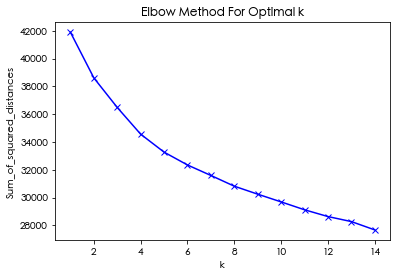

array([ 7,  4,  5,  2,  4,  0,  4,  1, 11,  9,  6,  4,  5,  5,  1,  8,  9,
       10,  4,  0,  4,  0, 10,  4,  3,  5,  5, 13,  4,  1,  5,  5,  4,  5,
        0,  6,  4,  7,  0,  1,  4,  4,  0, 10,  4,  7,  0,  6,  0,  1,  5,
        5,  8,  8,  2, 11,  4, 10,  6,  0,  4,  8,  6,  4,  1,  7,  6, 11,
        6,  0,  4,  8,  8, 11,  2,  5,  1,  5,  1,  6,  1,  5, 13,  4,  6,
        5,  4,  1,  5,  5,  1,  4,  6,  4,  4,  1,  2, 11,  4,  7,  6,  1,
        0,  7,  1,  3,  0,  1,  8,  6, 13, 10,  6,  1,  5,  0,  5, 11,  7,
        9,  0,  6,  0,  4,  6,  0,  8,  8, 13,  8,  5, 13,  6,  5,  4,  2,
        3,  4,  5, 11, 11,  6, 13,  5,  5,  4,  3,  5,  1,  0,  5, 13,  8,
        8,  8,  1, 13,  1,  8,  8,  6,  6,  8,  4, 12,  3,  5,  1, 13,  0,
        8,  8,  5,  6,  1,  0,  4, 11,  4,  6,  0,  1,  8, 13,  5,  7, 11,
        4,  8,  7,  8,  6,  0,  4, 12,  8,  8,  4,  8, 13,  6,  0, 13, 11,
        6, 11,  8,  4,  6,  5,  5,  8,  1,  5,  0,  6, 13,  4,  6,  6,  1,
        4,  0,  3,  7, 12

In [85]:
# Run Elbow to decide K for k-means
elbow_plot(titles_embeddings)

In [139]:
# As clustering algorithm KMeams is a perfect fit.
num_clusters = 3
t_clf = KMeans(n_clusters=num_clusters, 
            max_iter=100, 
            init='k-means++', 
            n_init=1)
t_clf.fit_predict(titles_embeddings)
t_cluster_assignment = t_clf.labels_

t_cdf=pd.DataFrame(columns=["cluster_id","sentence_id","sentence"])

for i in range(len(t_cluster_assignment)):
    new_row=pd.Series(data={"cluster_id":t_cluster_assignment[i],
                                "sentence_id":i,
                                "sentence":titles[i]
                           }
                            )
    t_cdf=t_cdf.append(new_row,ignore_index=True)

t_cdf.head()

cluster_id sentence_id                                           sentence
0          0           0  Young Professional Consultant (w/m/d) Analytic...
1          1           1                               AI/ML Data Scientist
2          1           2                              Senior Data Scientist
3          0           3                              Junior Data Scientist
4          1           4                            Delivery Data Scientist

In [162]:
# Using PCA to reduce the dimension to project the result to 2-d scatter plot

t_pca = PCA(n_components=2)
t_principalComponents = t_pca.fit_transform(titles_embeddings)


df_tpca = pd.DataFrame(data = t_principalComponents
             , columns = ['principal component 1', 'principal component 2'])

df_tpca['titles']=titles

In [163]:
# Combine PCA results with K-means results to see clustering
df_tk=df_tpca.merge(t_cdf,right_on=['sentence'],left_on=['titles'])

In [164]:
    height=600
    width=800
    # Create scatter plot to display death and confirmed cases by countries
    tscat=alt.Chart(df_tk).mark_circle(size=100).encode(
        y=alt.Y("principal component 1", axis=alt.Axis(format='f', title='PC 1')),
        x=alt.X("principal component 2",axis=alt.Axis(format='f', title='PC 2')),
        #color=alt.condition(select_country,alt.value("red"),alt.value("#66B2FF")),
        color=alt.Color('cluster_id', scale=alt.Scale(scheme='accent')),
        tooltip=["titles"]
    ).properties(
        height=height, width=width,
        title = alt.TitleParams(text = 'Clusters of titles',
                                anchor='middle',
                                font = 'Ubuntu Mono', 
                                fontSize = 16, 
                                color = '#3E454F', 
                                )
    )
    tscat

alt.Chart(...)

In [95]:
tf_vectorizer = CountVectorizer(strip_accents = 'unicode',
                                stop_words = 'english',
                                lowercase = True,
                                token_pattern = r'\b[a-zA-Z]{3,}\b',
                                max_df = 0.5, 
                                min_df = 10)
dtm_tf = tf_vectorizer.fit_transform(df_main['title'])
tfidf_vectorizer = TfidfVectorizer(**tf_vectorizer.get_params())
dtm_tfidf = tfidf_vectorizer.fit_transform(df_main['title'])

In [98]:
# Using LDA to cluster skills
lda_tf = LatentDirichletAllocation(n_components=4, random_state=0)
lda_tf.fit(dtm_tf)
# for TFIDF DTM
lda_tfidf = LatentDirichletAllocation(n_components=4, random_state=0)
lda_tfidf.fit(dtm_tfidf)

LatentDirichletAllocation(n_components=4, random_state=0)

In [99]:
pyLDAvis.sklearn.prepare(lda_tf, dtm_tf, tf_vectorizer)

PreparedData(topic_coordinates=              x         y  topics  cluster       Freq
topic                                                
0      0.250659 -0.275079       1        1  30.775448
3     -0.171171 -0.032924       2        1  25.391027
2     -0.267158 -0.012120       3        1  22.045047
1      0.187670  0.320122       4        1  21.788479, topic_info=         Term       Freq      Total Category  logprob  loglift
8        lead  55.000000  55.000000  Default  19.0000  19.0000
7      junior  38.000000  38.000000  Default  18.0000  18.0000
1   analytics  37.000000  37.000000  Default  17.0000  17.0000
13  principal  34.000000  34.000000  Default  16.0000  16.0000
9    learning  30.000000  30.000000  Default  15.0000  15.0000
..        ...        ...        ...      ...      ...      ...
5    engineer   0.266539  29.319571   Topic4  -5.8829  -3.1767
9    learning   0.268332  30.234357   Topic4  -5.8762  -3.2007
13  principal   0.268901  34.629525   Topic4  -5.8741  -3.3343
7      junior   0.264598  38.589378   Topic4  -5.8903  -3.4587
8        lead   0.265003  55.771909   Topic4  -5.8887  -3.8255

[95 rows x 6 columns], token_table=      Topic      Freq        Term
term                             
0         1  0.954399     analyst
1         4  0.974477   analytics
2         4  0.950626     applied
3         2  0.945017   associate
4         2  0.639932  consultant
4         3  0.284414  consultant
5         1  0.989100    engineer
6         2  0.907733      intern
7         3  0.984727      junior
8         2  0.986160        lead
9         1  0.959174    learning
10        1  0.982161     machine
11        4  0.950340     manager
12        2  0.935687         nlp
13        3  0.981821   principal
14        1  0.920975     product
15        3  0.955123    research
16        1  0.579493     science
16        2  0.193164     science
16        4  0.193164     science
17        1  0.889701  scientists
18        4  0.950647       stage, R=19, lambda_step=0.01, plot_opts={'xlab': 'PC1', 'ylab': 'PC2'}, topic_order=[1, 4, 3, 2])

In [114]:
def top_tfidf_feats(row, features, top_n=20):
    topn_ids = np.argsort(row)[::-1][:top_n]
    top_feats = [(features[i], row[i]) for i in topn_ids]
    df = pd.DataFrame(top_feats, columns=['features', 'score'])
    return df

def top_feats_in_doc(X, features, row_id, top_n=25):
    row = np.squeeze(X[row_id].toarray())
    return top_tfidf_feats(row, features, top_n)

def top_mean_feats(X, features, grp_ids=None, min_tfidf=0.1, top_n=25):
    if grp_ids:
        D = X[grp_ids].toarray()
    else:
        D = X.toarray()

    D[D < min_tfidf] = 0
    tfidf_means = np.mean(D, axis=0)
    return top_tfidf_feats(tfidf_means, features, top_n)

In [144]:

stemmer = SnowballStemmer("english")
def tokenize_and_stem(text):
    # first tokenize by sentence, then by word to ensure that punctuation is caught as it's own token
    tokens = [word for sent in nltk.sent_tokenize(text) for word in nltk.word_tokenize(sent)]
    filtered_tokens = []
    # filter out any tokens not containing letters (e.g., numeric tokens, raw punctuation)
    for token in tokens:
        if re.search('[a-zA-Z]', token):
            filtered_tokens.append(token)
    stems = [stemmer.stem(t) for t in filtered_tokens]
    return stems

def tokenize_only(text):
    # first tokenize by sentence, then by word to ensure that punctuation is caught as it's own token
    tokens = [word.lower() for sent in nltk.sent_tokenize(text) for word in nltk.word_tokenize(sent)]
    filtered_tokens = []
    # filter out any tokens not containing letters (e.g., numeric tokens, raw punctuation)
    for token in tokens:
        if re.search('[a-zA-Z]', token):
            filtered_tokens.append(token)
    return filtered_tokens

In [145]:
# At this point we are going to tokenize the bodies and convert them
# into a document-term matrix.

# Some note on min_df and max_df
# max_df=0.5 means "ignore all terms that appear in more then 50% of the documents"
# min_df=2 means "ignore all terms that appear in less then 2 documents"
stopwords = ENGLISH_STOP_WORDS.union(['data','scientist'])
vect = TfidfVectorizer(analyzer='word', stop_words=stopwords, max_df=0.5, min_df=2,use_idf=True,max_features=200000, 
                       tokenizer=tokenize_only,ngram_range=(1,3))

X = vect.fit_transform(df_tk['titles'].values)
print(X.shape)
features = vect.get_feature_names()

(437, 297)


In [146]:
def top_feats_per_cluster(X, y, features, min_tfidf=0.1, top_n=25):
    dfs = []

    labels = np.unique(y)
    for label in labels:
        ids = np.where(y==label) 
        feats_df = top_mean_feats(X, features, ids, min_tfidf=min_tfidf, top_n=top_n)
        feats_df.label = label
        dfs.append(feats_df)
    return dfs

def plot_tfidf_classfeats_h(dfs):
    fig = plt.figure(figsize=(15, 9+len(dfs)*6), facecolor="w")
    x = np.arange(len(dfs[0]))
    for i, df in enumerate(dfs):
        ax = fig.add_subplot(len(dfs),3, i+1)
        ax.spines["top"].set_visible(False)
        ax.spines["right"].set_visible(False)
        ax.set_frame_on(False)
        ax.get_xaxis().tick_bottom()
        ax.get_yaxis().tick_left()
        ax.set_xlabel("Tf-Idf Score", labelpad=16, fontsize=14)
        ax.set_title("cluster = " + str(df.label), fontsize=16)
        ax.ticklabel_format(axis='x', style='sci', scilimits=(-2,2))
        ax.barh(x, df.score, align='center', color='#7530FF')
        ax.set_yticks(x)
        ax.set_ylim([-1, x[-1]+1])
        yticks = ax.set_yticklabels(df.features)
        plt.subplots_adjust(bottom=0.09, right=0.97, left=0.15, top=0.95, wspace=0.52)
    plt.show()

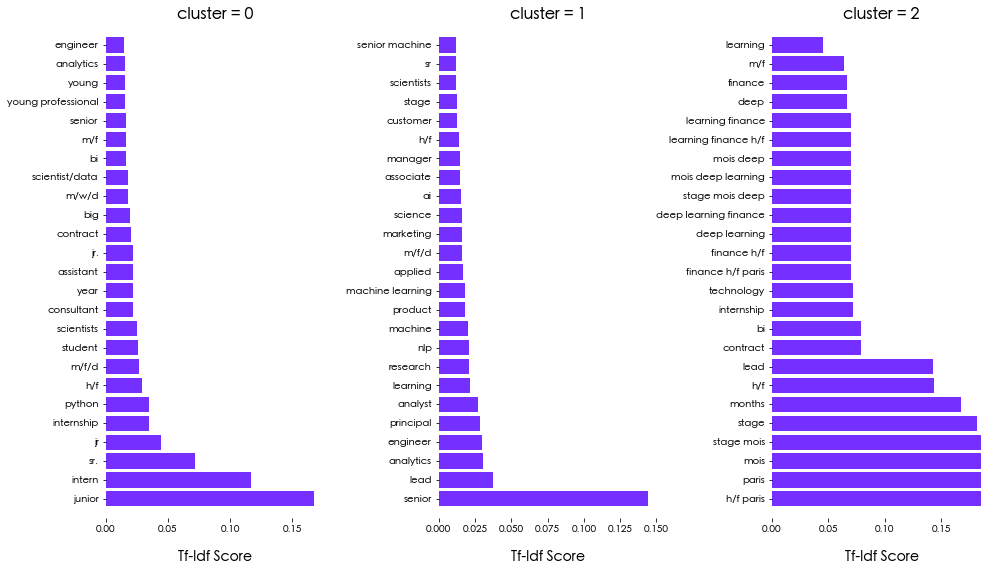

In [147]:
#Use this to print the top terms per cluster with matplotlib.
plot_tfidf_classfeats_h(top_feats_per_cluster(X, t_clf.labels_, features, 0.1, 25))

In [ ]:
# The above is more than clear, the tiltes are consisted of 3 types: junior, senior, and others

In [154]:
#dist = 1 - cosine_similarity(X)
dist = 1 - cosine_similarity(titles_embeddings)

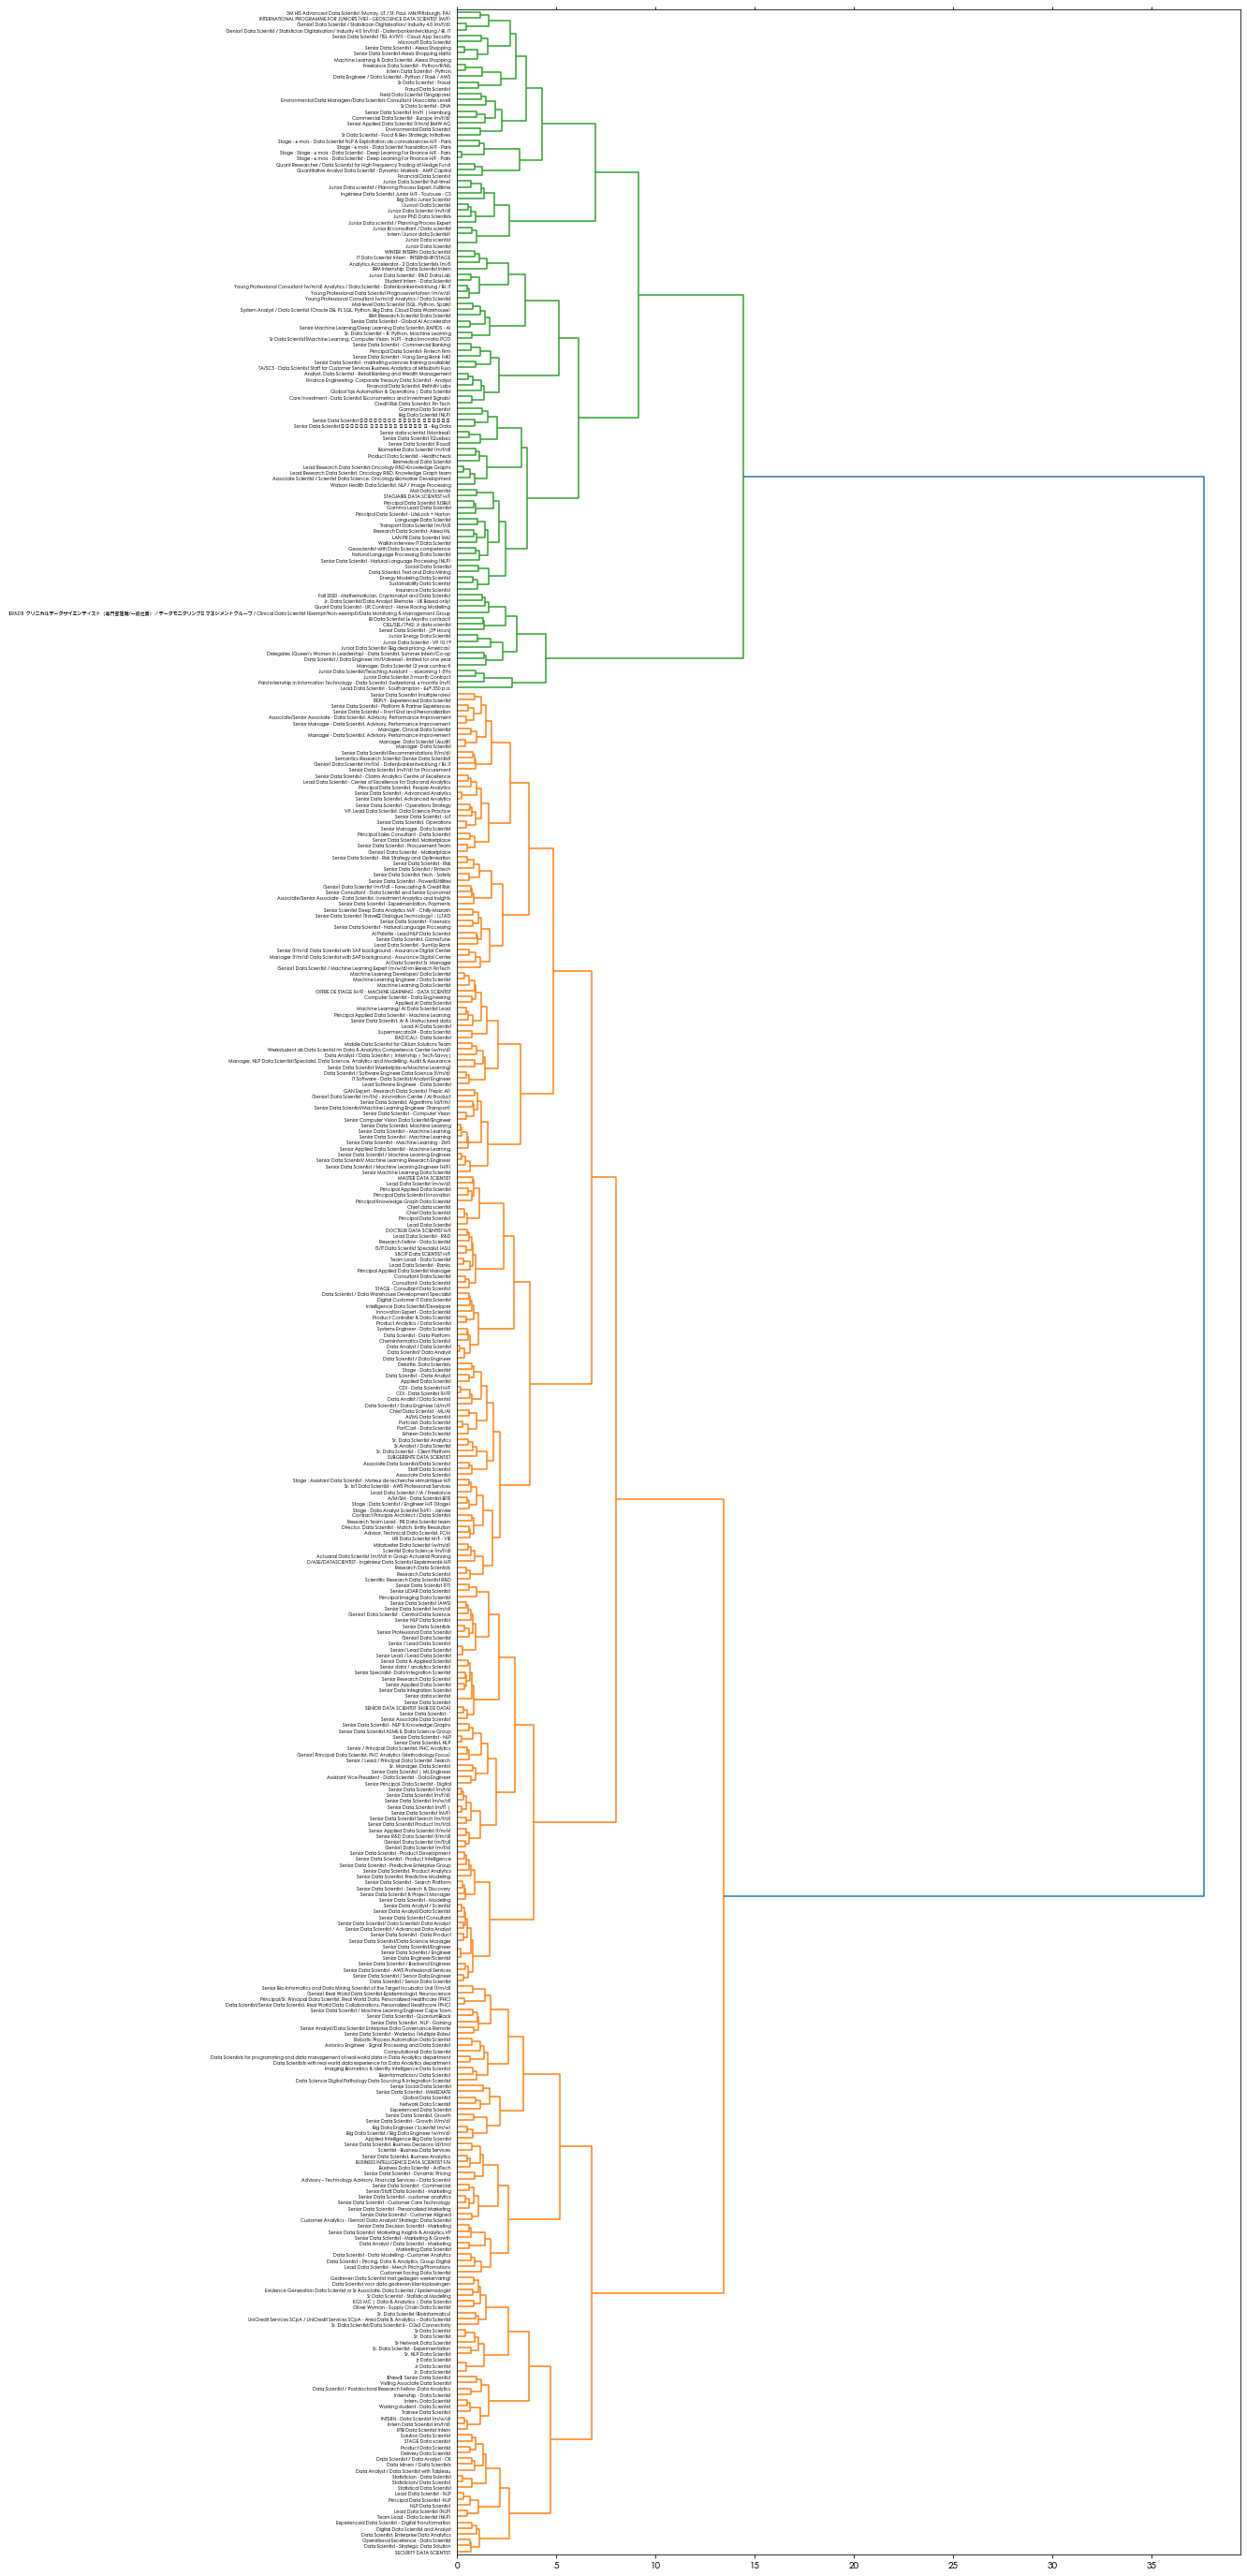

<Figure size 432x288 with 0 Axes>

In [156]:


linkage_matrix = ward(dist) #define the linkage_matrix using ward clustering pre-computed distances

fig, ax = plt.subplots(figsize=(15,50)) # set size
ax = dendrogram(linkage_matrix, orientation="right", labels=df_tk['titles'].values);

plt.tick_params(\
    axis= 'x',          # changes apply to the x-axis
    which='both',      # both major and minor ticks are affected
    bottom='off',      # ticks along the bottom edge are off
    top='off',         # ticks along the top edge are off
    labelbottom='off')

#plt.tight_layout() #show plot with tight layout
plt.show()
#uncomment below to save figure
plt.savefig('ward_clusters.png', dpi=600) #save figure as ward_clusters

In [165]:
# Perform EDA to check main table
d3 = dtale.show(df_tk)
d3.open_browser()